<font size=6> Sentiment analysis </font>

<font size=3>
 利用<font color=yellow> CNN、LSTM </font>
 兩種深度學習網路萃取評論特徵向量，預測喜好餐廳與否 (0, 1)
</font> <br/>
<font> 評分 1 ~ 5，將 4 分以上視為正評(1)，其餘視為 0 </font>

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import ZeroPadding2D,Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers.recurrent import LSTM

In [58]:
# 畫圖用
import matplotlib.pyplot as plt
def show_train_history(train, val):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel(train)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


<font size=5> Preprocess </font>

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

my_col = ['stars', 'text']
data = pd.read_csv('yelp.csv', usecols=my_col)
data_X = data['text']
stop_words2 = ['\n','0','1','2','3','4','5','6','7','8','9']
stop_words3 = [',', '.', '!', '?', ':', '-', '(', ')']
for st2 in stop_words2:
    data_X = data_X.apply( lambda x: x.replace(st2, '') )
for st3 in stop_words3:
    data_X = data_X.apply( lambda x: x.replace(st3, ' ') )
data_X = data_X.apply( lambda x: x.lower() )
data_X = data_X.apply(lambda x: x.split(' '))
data_X = data_X.tolist()
data_Y = np.where(data['stars']>=4, 1, 0 )

In [85]:
# 引入 stop words 字典
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
vectorizer = CountVectorizer(stop_words='english', max_df=0.8)
# 清除 stop words
stop_words = vectorizer.get_stop_words()
data['text'] = data['text'].apply(lambda x: ' '.join( [word for word in x.split(' ') if word not in stop_words] ))
    
# 分割訓練、測試資料
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, random_state=33, train_size=0.8)

# 將文字編號，並將每篇評論設定為 380 個字
token = Tokenizer(num_words=3800)
token.fit_on_texts(train_X)
train_X_seq = token.texts_to_sequences(train_X)
test_X_seq = token.texts_to_sequences(test_X)
train_X_cnn = sequence.pad_sequences(train_X_seq, maxlen=380)
test_X_cnn = sequence.pad_sequences(test_X_seq, maxlen=380)

<font size=5> CNN </font>

In [86]:
# construct cnn model
model = Sequential()
model.add( Embedding(output_dim=32, input_dim=3800, input_length=380) )
# output_dim : 輸出的維度是32，希望將數字list轉換為32維度的向量
# input_dim : 輸入的維度是3800，也就是我們之前建立的字典是3800字
# input_length : 每則評論有380個字
model.add( Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu') )
model.add( Dropout(0.3) )
model.add( GlobalMaxPooling1D() )
model.add( Dense(units=1024, activation='relu') )
model.add( Dropout(0.3) )
model.add( Dense(units=1, activation='relu') )
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 380, 32)           121600    
                                                                 
 conv1d_14 (Conv1D)          (None, 379, 64)           4160      
                                                                 
 dropout_32 (Dropout)        (None, 379, 64)           0         
                                                                 
 global_max_pooling1d_14 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_32 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_33 (Dropout)        (None, 1024)              0         
                                                     

In [87]:
# 訓練方式
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model
train_history = model.fit(train_X_cnn, train_Y, batch_size=128, epochs=10, verbose=2, validation_split=0.25 )

Epoch 1/10
47/47 - 4s - loss: 0.9114 - accuracy: 0.6222 - val_loss: 0.6614 - val_accuracy: 0.6420 - 4s/epoch - 93ms/step
Epoch 2/10
47/47 - 4s - loss: 0.5771 - accuracy: 0.6947 - val_loss: 0.5955 - val_accuracy: 0.7040 - 4s/epoch - 86ms/step
Epoch 3/10
47/47 - 4s - loss: 0.5485 - accuracy: 0.7332 - val_loss: 0.6323 - val_accuracy: 0.6610 - 4s/epoch - 82ms/step
Epoch 4/10
47/47 - 4s - loss: 0.5223 - accuracy: 0.7590 - val_loss: 0.5621 - val_accuracy: 0.7300 - 4s/epoch - 81ms/step
Epoch 5/10
47/47 - 4s - loss: 0.4412 - accuracy: 0.8048 - val_loss: 0.5417 - val_accuracy: 0.7600 - 4s/epoch - 81ms/step
Epoch 6/10
47/47 - 4s - loss: 0.3630 - accuracy: 0.8555 - val_loss: 0.5590 - val_accuracy: 0.7805 - 4s/epoch - 82ms/step
Epoch 7/10
47/47 - 4s - loss: 0.2761 - accuracy: 0.9032 - val_loss: 0.6828 - val_accuracy: 0.7800 - 4s/epoch - 83ms/step
Epoch 8/10
47/47 - 4s - loss: 0.2576 - accuracy: 0.9115 - val_loss: 0.6801 - val_accuracy: 0.7400 - 4s/epoch - 83ms/step
Epoch 9/10
47/47 - 4s - loss: 0.

In [88]:
# CNN result
scores = model.evaluate(test_X_cnn, test_Y)
print('accuracy', scores)

63/63 [==============================] - 0s 6ms/step - loss: 0.9554 - accuracy: 0.8000
accuracy [0.9554147124290466, 0.800000011920929]


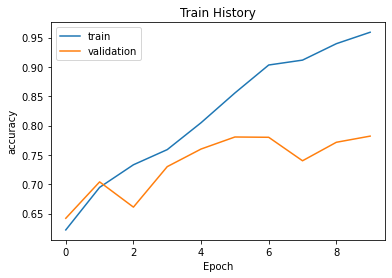

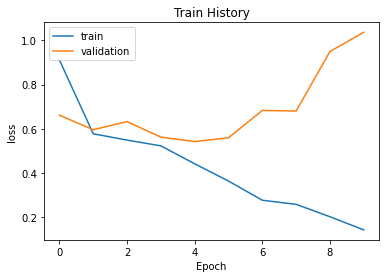

In [89]:
# 畫圖
show_train_history('accuracy', 'val_accuracy')
show_train_history('loss', 'val_loss')

<font size=5> LSTM </font>

In [38]:
# construct LSTM
model = Sequential()
model.add( Embedding(output_dim=32, input_dim=3800, input_length=380) )
model.add( Dropout(0.6) )
model.add( LSTM(32) )
model.add( Dense(units=1024, activation='relu') )
model.add( Dropout(0.6) )
model.add( Dense(units=1, activation='sigmoid') )
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 380, 32)           121600    
                                                                 
 dropout_16 (Dropout)        (None, 380, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_16 (Dense)            (None, 1024)              33792     
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 164,737
Trainable params: 164,737
Non-tr

In [39]:
# 訓練方式
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model
train_history = model.fit(train_X, train_Y, batch_size=64, epochs=10, verbose=2, validation_split=0.25 )

Epoch 1/10
94/94 - 23s - loss: 0.6028 - accuracy: 0.6932 - val_loss: 0.5117 - val_accuracy: 0.7690 - 23s/epoch - 243ms/step
Epoch 2/10
94/94 - 21s - loss: 0.4212 - accuracy: 0.8153 - val_loss: 0.4561 - val_accuracy: 0.7845 - 21s/epoch - 222ms/step
Epoch 3/10
94/94 - 21s - loss: 0.3121 - accuracy: 0.8682 - val_loss: 0.4628 - val_accuracy: 0.7840 - 21s/epoch - 222ms/step
Epoch 4/10
94/94 - 21s - loss: 0.2630 - accuracy: 0.8960 - val_loss: 0.4621 - val_accuracy: 0.8100 - 21s/epoch - 224ms/step
Epoch 5/10
94/94 - 21s - loss: 0.2255 - accuracy: 0.9118 - val_loss: 0.4945 - val_accuracy: 0.8040 - 21s/epoch - 223ms/step
Epoch 6/10
94/94 - 21s - loss: 0.2028 - accuracy: 0.9200 - val_loss: 0.4758 - val_accuracy: 0.8020 - 21s/epoch - 224ms/step
Epoch 7/10
94/94 - 21s - loss: 0.1788 - accuracy: 0.9313 - val_loss: 0.5645 - val_accuracy: 0.7945 - 21s/epoch - 223ms/step
Epoch 8/10
94/94 - 21s - loss: 0.1605 - accuracy: 0.9400 - val_loss: 0.6445 - val_accuracy: 0.8000 - 21s/epoch - 224ms/step
Epoch 9/

In [40]:
# LSTM result
scores = model.evaluate(test_X, test_Y)
print('accuracy', scores)

63/63 [==============================] - 2s 27ms/step - loss: 0.6545 - accuracy: 0.7755
accuracy [0.6545370817184448, 0.7754999995231628]


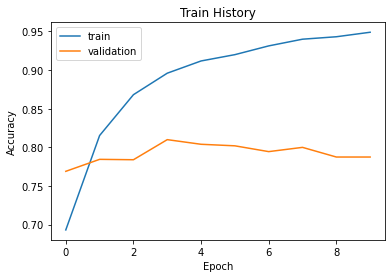

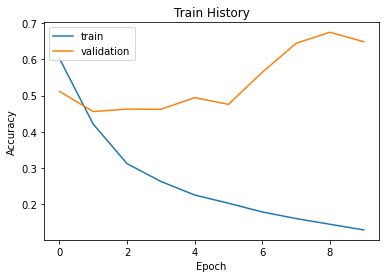

In [41]:
# 畫圖
show_train_history('accuracy', 'val_accuracy')
show_train_history('loss', 'val_loss')